# Taryn Michael | 201800323
# Advanced Machine Learning
# Assignment 4: Gaussian Process Regression

## Gaussian Process Regression

Gaussian process regression (GPR) is a nonparametric, Bayesian approach to regression that is making waves in the area of machine learning. GPR has several benefits, working well on small datasets and having the ability to provide uncertainty measurements on the predictions.

Since it is nonparametric (i.e. not limited by a functional form), rather than calculating the probability distribution of parameters of a specific function, GPR calculates the probability distribution over all admissible functions that fit the data. However, we specify a prior (on the function space), calculate the posterior using the training data, and compute the predictive posterior distribution on our points of interest.

Gaussian Process Regression can also be conceptualized in the function-space view, in which the learner learns a distribution over functions by learning mean and covariance functions of the realization of the GP at x, denoted by f(x).




The realization of a GP given by f(x) corresponds to a random variable. With these functions specified, f(x) can be sampled from the GP according to:





This is a formalization of sampling a random variable f(x) that depends on location x (for spatial applications; for time series applications, f(x) could depend on time t).
Estimates of the mean of f(x) are produced as a linear combination of observed target values y. The weighting coefficients used to produce these mean estimates are independent of the target values, placing Gaussian Process Regression models into the class of linear smoothers.


Given a training dataset consisting of N observations:



As well as a test dataset consisting of N’ points:



GPR predicts a posterior Gaussian distribution for targets over test points X∗ by computing the parameters of this Gaussian distribution given observed training data. We can think of this prediction as quite literally predicting a Gaussian distribution at each test point.

# Objective:

Given $X = [0 , 0.1 , 2 , 4]$ & $Y = [4 , 0.9 , 3.6 , 5]$ , implement a Gaussian Process Regression from first principle to find the function that models the relationship between $X$ and $Y$.

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [27]:
X = [0,0.1,2,4]
Y = [4,0.9,3.6,5]

**Plotting relationship between x and y**

Let us plot the $X$ & $Y$ values to get an indication of what the function which models them may look like.

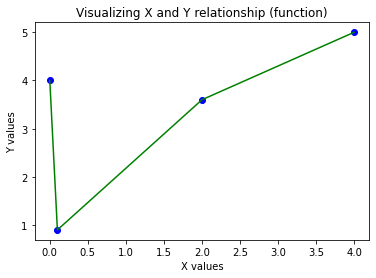

In [5]:
plt.plot(X,Y, label = "Y(X)", color='green')
plt.scatter(X,Y, color='blue')
plt.title("Visualizing X and Y relationship (function)")
plt.xlabel('X values')
plt.ylabel('Y values')

plt.show()

Now, let us specify new datapoints for X which we will take as our priors.

We also specify the Kernel (covariance function) we will be using. 
Covariance functions are a crucial component of GPR models, since these functions weight the contributions of training points to predicted test targets according to the kernel distance between observed training points $X$ and test points $X_*$.

The predicted means at test points $X_∗$, in fact, can be expressed as:
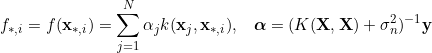
In this case, our Covariance Function is the Squared Exponential Kernel, also known as the Radial Basis Function Kernel.

It can be computed as:

$k(x_a, x_b) = \sigma^2 \exp \left(-\frac{ \left\Vert x_a - x_b \right\Vert^2}{2\ell^2}\right)$

With:

- $\sigma^2$ the overall variance ( $\sigma$ is also known as amplitude).
- $\ell$ the lengthscale.

It is very appropriate for modelling smooth functions, which, based on our plot above, makes it appropriate to use in this case. However, it can be integrated against most functions. This is due to it being universal and that every function in its prior has infinitely many derivates.

In [56]:
n = 100
x_prior = np.linspace(-2,4,n)

#Kernel function
def Kernel(X, ℓ=1):
 """exponentiated quadratic kernel"""
 return np.array([np.exp(-(X-xi)**2 / (2*ℓ**2)) for xi in X])


A gaussian process can be defined as:

_"The collection of random variables indexed by time or space, such that every finite
collection of those random variables has a multivariate normal distribution, i.e. every finite
linear combination of them is normally distributed."_

However, in practise we do not need to directly work with this infinite mathematical object. We instead only evaluate the Gaussian Processes at our data points. In this way, we collapse it into a finite multivariate Gaussian Distribution with as many dimensions as there are  data points.

In [57]:
Kern_prior = Kernel(x_prior)
μ_prior = np.zeros_like(x_prior)
Y_prior = np.random.multivariate_normal(μ_prior, Kern_prior, 10)

**Joint Distributions**

The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space.
The independent Gaussian vector points are being connected to generate the functions. This is not smooth enough for regression tasks. Thus, these points need to be correlated together as a joint Gaussian Distribution.

In [58]:
X_j = np.r_[X, x_prior]
Kern_j = Kernel(X_j)

In [59]:
n1 = len(X)
K_j = Kern_j[:n1, :n1]
K_x = Kern_j[n1:, :n1]
K_xx = Kern_j[n1:,n1:]


**Inference**

To calculate the predictive posterior distribution, the data and the test observation is conditioned out of the posterior distribution. Again, because we chose a Gaussian process prior, calculating the predictive distribution is tractable, and leads to normal distribution that can be completely described by the mean and variance 

In [60]:
μ_post = K_x@np.linalg.inv(K_j)@Y
K_post = K_xx - K_x@np.linalg.inv(K_j)@K_x.T
Y_post = np.random.multivariate_normal(μ_post, K_post, 10)

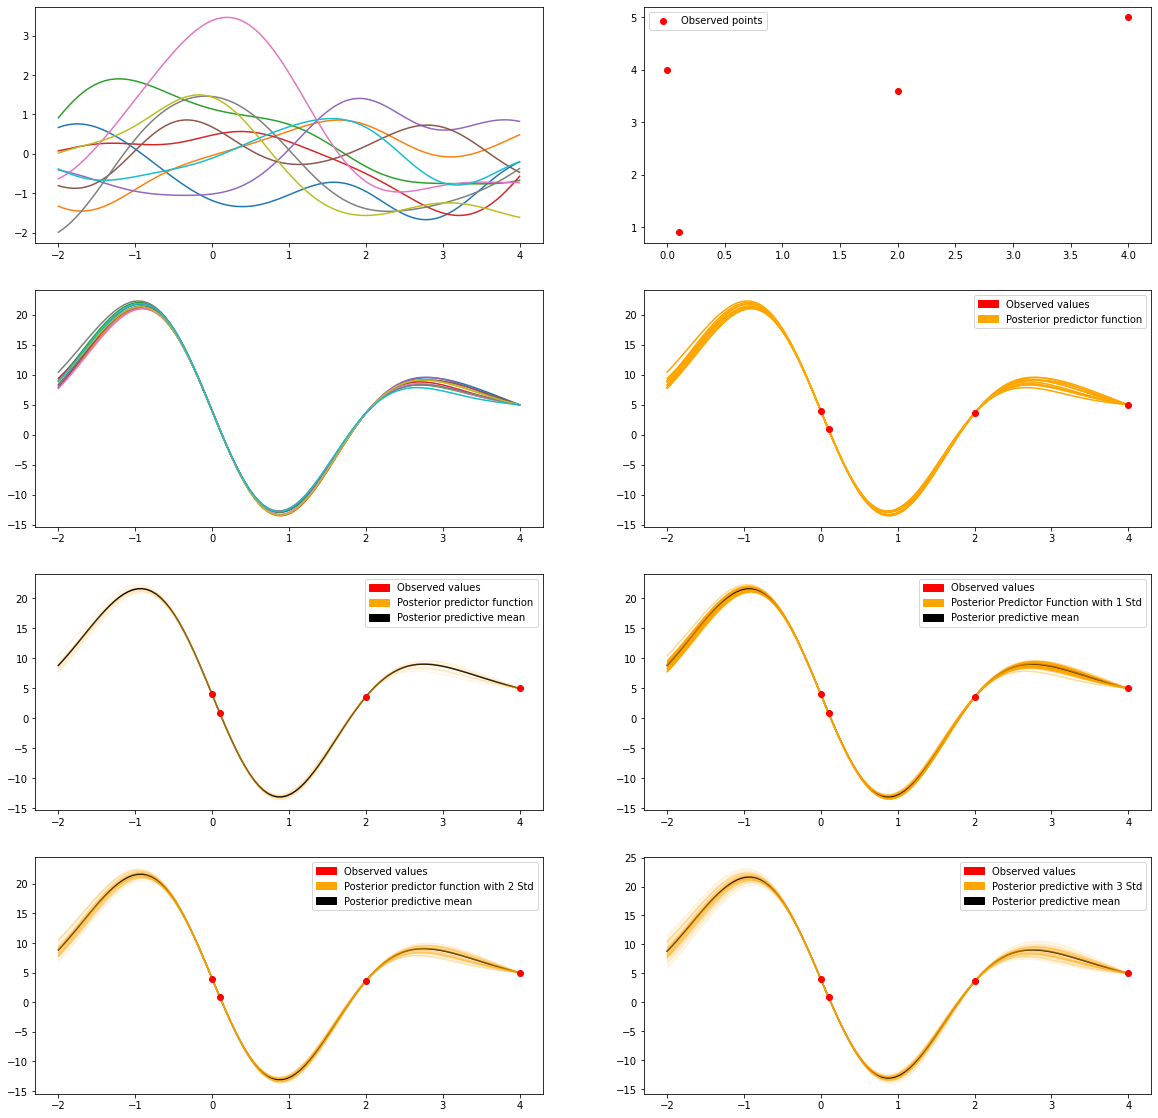

In [61]:
_,ax = plt.subplots(4,2, figsize=(20,20));
ax[0,0].plot(x_prior, Y_prior.T);
ax[0,1].scatter(X, Y, color='red', label = 'Observed points');
ax[0,1].legend();
ax[1,0].plot(x_prior, Y_post.T);


ax[1,1].plot(x_prior, Y_post.T, color='orange');
ax[1,1].scatter(X,Y, zorder=3, color='red');
observed_patch = mpatches.Patch(color='red', label='Observed values')
posterior_patch = mpatches.Patch(color='orange', label='Posterior predictor function')
ax[1,1].legend(handles=[observed_patch, posterior_patch], loc = 'upper right');


ax[2,0].plot(x_prior, μ_post, color='black');
ax[2,0].plot(x_prior, Y_post.T, color='orange', alpha=0.1);
ax[2,0].scatter(X,Y, zorder=3, color='red');
postmean_patch = mpatches.Patch(color='black', label='Posterior predictive mean')
ax[2,0].legend(handles=[observed_patch, posterior_patch, postmean_patch], loc = 'upper right');

ax[2,1].fill_between(x_prior, μ_post + np.sqrt(np.diag(K_post)),
                    μ_post - np.sqrt(np.diag(K_post)), color='orange')
ax[2,1].plot(x_prior, μ_post, color='black');
ax[2,1].plot(x_prior, Y_post.T, color='orange', alpha=0.4);
ax[2,1].scatter(X,Y, zorder=3, color='r');
posterior1std_patch = mpatches.Patch(color='orange', label='Posterior Predictor Function with 1 Std')
ax[2,1].legend(handles=[observed_patch, posterior1std_patch, postmean_patch], loc = 'upper right');

ax[3,0].fill_between(x_prior, μ_post + np.sqrt(np.diag(K_post)),
                    μ_post - np.sqrt(np.diag(K_post)), color='orange', alpha=0.1)
ax[3,0].fill_between(x_prior, μ_post + 2*np.sqrt(np.diag(K_post)),
                    μ_post - 2*np.sqrt(np.diag(K_post)), color='orange', alpha=0.1)
ax[3,0].plot(x_prior, μ_post, color='black');
ax[3,0].plot(x_prior, Y_post.T, color='orange', alpha=0.3);
ax[3,0].scatter(X,Y, zorder=3, color='red');
posterior2std_patch = mpatches.Patch(color='orange', label='Posterior predictor function with 2 Std')
ax[3,0].legend(handles=[observed_patch, posterior2std_patch, postmean_patch], loc = 'upper right');

ax[3,1].fill_between(x_prior, μ_post + np.sqrt(np.diag(K_post)),
                    μ_post - np.sqrt(np.diag(K_post)), color='orange', alpha=0.1)
ax[3,1].fill_between(x_prior, μ_post + 2*np.sqrt(np.diag(K_post)),
                    μ_post - 2*np.sqrt(np.diag(K_post)), color='orange', alpha=0.1)
ax[3,1].fill_between(x_prior, μ_post + 3*np.sqrt(np.diag(K_post)),
                    μ_post - 3*np.sqrt(np.diag(K_post)), color='orange', alpha=0.1)
ax[3,1].plot(x_prior, μ_post, color='black');
ax[3,1].plot(x_prior, Y_post.T, color='orange', alpha=0.3);
ax[3,1].scatter(X,Y, zorder=3, color='r');
posterior3std_patch = mpatches.Patch(color='orange', label='Posterior predictive with 3 Std')
ax[3,1].legend(handles=[observed_patch, posterior3std_patch, postmean_patch], loc = 'upper right');

Using the Squared Exponential Kernel with $\ell=1$, we can see that our model fits the observed data points quite well. 